# Laboratory work 11
## Noise statistics identification to construct tracking filter of a moving object
## Group 1: Viktor Liviniuk, Alina Liviniuk
## Skoltech
## 2017

The objective of this laboratory work is to develop a tracking filter of a moving object on the basis of noise statistics identification which specification is crucial for optimal assimilation output. This will bring a deeper understanding of main difficulties of practical Kalman filter implementation and skills to overcome these difficulties. 

## Part I. Noise statistics identification

Generate a true trajectory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
q = 6
N = 500000
x1 = 5
V1 = 1
T = 1
sigma_a = 3
sigma_eta = 10

In [3]:
def generate_trajectory(N, x1, V1, T, q, sigma_a):
    a = np.random.normal(q, sigma_a, N)
    x = np.zeros(N)
    V = np.zeros(N)
    x[0] = x1
    V[0] = V1
    for i in range(1,N):
        x[i] = x[i-1] + V[i-1]*T + a[i-1]*T**2/2
        V[i] = V[i-1] + a[i-1]*T
    return [x, V]

In [4]:
[x, V] = generate_trajectory(N, x1, V1, T, q, sigma_a)
time = T*np.array(range(N))

Now generate measurements

In [5]:
def generate_measurements(x, sigma_eta):
    eta = np.random.normal(0, sigma_eta, x.size)
    return x + eta

In [6]:
z = generate_measurements(x, sigma_eta)

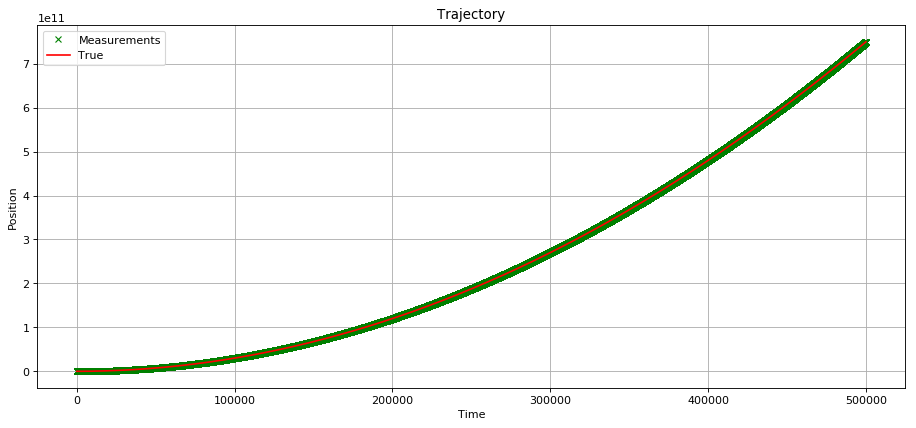

In [7]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time, z, 'gx', label='Measurements')
plt.plot(time, x, 'r-', label='True')
plt.title('Trajectory')
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

The trajectory is pretty big and in this scale it visually merges with measurements on plot.

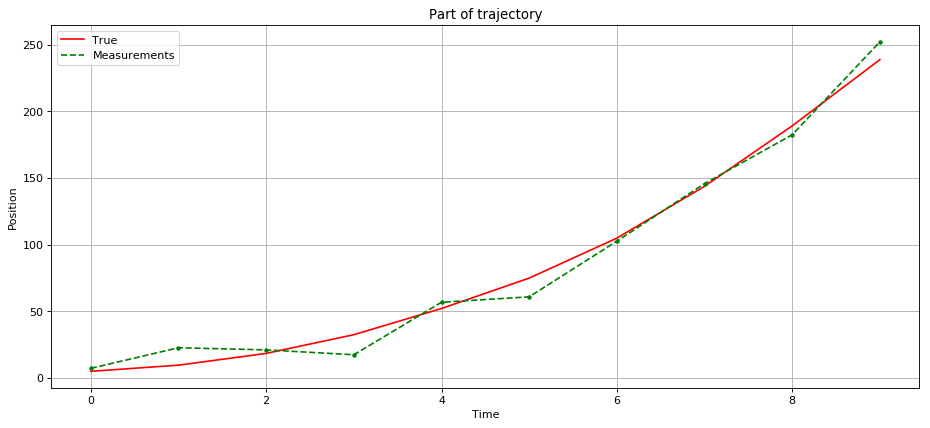

In [8]:
# Plot a closer look
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time[:10], x[:10], 'r-', label='True')
plt.plot(time[:10], z[:10], 'g.')
plt.plot(time[:10], z[:10], 'g--', label='Measurements')
plt.title('Part of trajectory')
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

Identify bias q, standard deviation sigma_a, and standard deviation sigma_eta using measurements z.

In [9]:
nu = np.zeros(N-2) # shifted by 2
ro = np.zeros(N-3) # shifted by 3
for i in range(2,N):
    nu[i-2] = z[i] - 2*z[i-1] + z[i-2]
for i in range(3,N):
    ro[i-3] = z[i] - 3*z[i-2] + 2*z[i-3]
Exp_nu = np.mean(nu)
q_determined = Exp_nu/T**2
Exp1 = np.mean((nu - q*T**2)**2)
Exp2 = np.mean((ro - 3*q*T**2)**2)
sigma_eta_determined = ((7*Exp1-Exp2)/28)**.5
sigma_a_determined = ((2*Exp1 - 12*sigma_eta_determined**2)/T**4)**.5

In [10]:
sigmas = [[q, sigma_a, sigma_eta],[q_determined, sigma_a_determined, sigma_eta_determined]]
indicators = ['true', 'determined']
col = ['q', 'sigma_a', 'sigma_eta']
table = pd.DataFrame(data=sigmas, index=indicators, columns=col, dtype=None, copy=False)
table.round(decimals=3).head(2)

,q,sigma_a,sigma_eta
true,6.000,3.00,10.000
determined,5.996,3.05,9.999


The determined values are pretty close to the true ones.

## Part II.  Tracking filter of a moving object on the basis of noise statistics identification and sensitivity analysis of assimilation output to choice of noise statistics

Generate a new trajectory with measurements.

In [11]:
N = 200
q = 6
sigma_a = 3
sigma_eta = 10
x1 = 5
V1 = 1
T = 1

In [12]:
[x, V] = generate_trajectory(N, x1, V1, T, q, sigma_a)
time = T*np.array(range(N))
z = generate_measurements(x, sigma_eta)

Make a state vector X:

In [13]:
X = np.array([x,V])

In [14]:
X0 = np.array([[2], [0]])
P00 = np.eye(2) * 10e10

Kalman Filter algorithm for 1D:

In [15]:
H = np.array([1, 0])
F = np.array([[1,T],[0,1]])
G = np.array([[T**2/2],[T]])
R = np.array([sigma_eta_determined**2])
Q = G*np.transpose(G)*sigma_a_determined**2

In [16]:
# Kalman Filter
def KalmanFilter(z, Xf0, P00, R, F, Q, H, T, q, G):
    "returns Kalman filter estimates Xf and Xp (state vectors filtration and prediction) of given measurements z"
    N = z.size
    if np.size(z.shape) == 1:
        n = 1
    else:
        n = z.shape[0]
    Xp = np.zeros((2*n,N))
    Xp[:,0] = Xf0[:,0]
    Xf = np.zeros((2*n,N))
    Xf[:,0] = Xf0[:,0]
    Ht = np.transpose(np.array([H]))
    Ft = np.transpose(F)
    I = np.eye(2*n)
    K = np.zeros((2*n,n,N))
    Pp = np.zeros((2*n,2*n,N))
    Pp[:,:,0] = P00
    Pf = np.zeros((2*n,2*n,N))
    Pf[:,:,0] = P00
    for i in range(1, N):
        # prediction
        Xp[:,i] = np.matmul(F, Xf[:,i-1]) + (G*q)[:,0]
        Pp[:,:,i] = np.matmul(np.matmul(F, Pf[:,:,i-1]), Ft) + Q
        # filtration
        K[:,:,i] = np.matmul(Pp[:,:,i], (Ht * (np.matmul(np.matmul(H, Pp[:,:,i]), Ht) + R)**-1))
        Xf[:,[i]] = Xp[:,[i]] + (K[:,:,i] * (z[:,i] - np.matmul(H, Xp[:,i])))
        Pf[:,:,i] = np.matmul(I - np.matmul(K[:,:,i], H.reshape((1,2))), Pp[:,:,i])
    return [Xf, Xp, Pf, Pp];

In [17]:
[Xf, Xp, Pf, Pp] = KalmanFilter(np.array([z]), X0, P00, R, F, Q, H, T, q_determined, G)

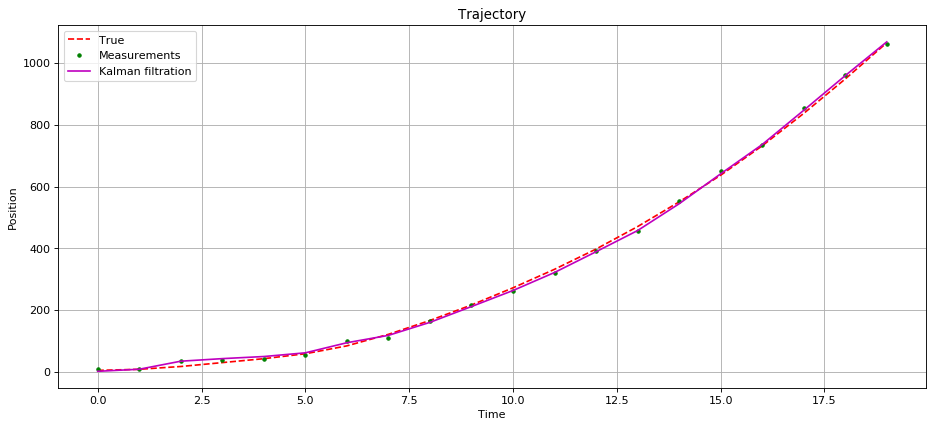

In [18]:
# Plot a closer look
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(time[:20], x[:20], 'r--', label='True')
plt.plot(time[:20], z[:20], 'g.', label='Measurements')
#plt.plot(time, z, 'g--', label='Measurements')
plt.plot(time[:20], Xf[0][:20], 'm-', label='Kalman filtration')
plt.title('Trajectory')
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

In Kalman Filter we used sigmas and q obtained previously, not the exact ones.

Now we run Kalman filtration for M = 500 times and calculate estimation errors

In [19]:
# Errors
def errors_run(e, v):
    "returns errors of estimation e of variable v"
    return (e - v) ** 2

In [20]:
def M_runs_plot(q_, sigma_a_, sigma_eta_):
    # set dependent on sigmas/q values
    R = np.array([sigma_eta_**2])
    Q = G*np.transpose(G)*sigma_a_**2
    
    # M runs
    M = 500
    ErrorRunXf = []
    ErrorRunXp = []
    Final_Error_Xf = []
    Final_Error_Xp = []
    K0M = []
    for i in range(M):
        [x, V] = generate_trajectory(N, x1, V1, T, q, sigma_a)
        z = generate_measurements(x, sigma_eta)
        [Xf, Xp, Pf, Pp] = KalmanFilter(np.array([z]), X0, P00, R, F, Q, H, T, q_, G)
        ErrorRunXf.append(errors_run(Xf[0], x))
        ErrorRunXp.append(errors_run(Xp[0], x))
        
    # Final Error Calculation
    Final_Error_Xf = (np.sum(ErrorRunXf, axis=0) / (M - 1)) ** .5
    Final_Error_Xp = (np.sum(ErrorRunXp, axis=0) / (M - 1)) ** .5
    
    # Plot
    plt.figure(figsize=(14, 6), dpi=80)
    plt.plot(time, Final_Error_Xp, 'r-', label = "Extrapolation")
    plt.plot(time[3:], (Pp[0,0,:]**.5)[3:], 'r--', label = "sqrt P extrapol.")
    plt.plot(time, Final_Error_Xf, 'b-', label = "Filtration")
    plt.plot(time[1:], (Pf[0,0,:]**.5)[1:], 'b--', label = "sqrt P filtr.")

    plt.grid()
    plt.legend()
    plt.title('Errors of extrapolation and filtration of x')
    plt.xlabel('Time')
    plt.ylabel('Final Error')
    plt.show()

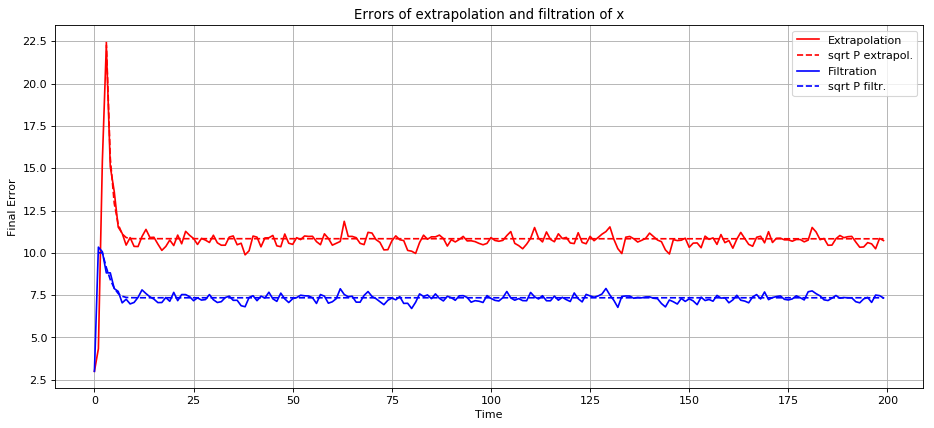

In [21]:
M_runs_plot(q_determined, sigma_a_determined, sigma_eta_determined)

Real errors of prediction/filtration are close to square roots of first elements of matrices P.

Now 500 runs will be implemented for different values for q, sigma_a, sigma_eta.

a) q = 0, other values as determined in Part I

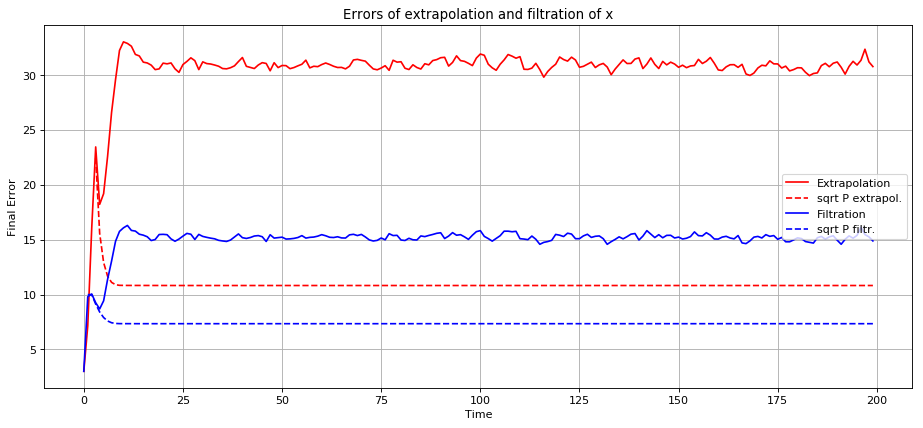

In [22]:
M_runs_plot(0, sigma_a_determined, sigma_eta_determined)

Not knowing the bias may increased error of prediction around around 3-fold. 

b) 10 times greater sigma_a, other values as determined in Part I

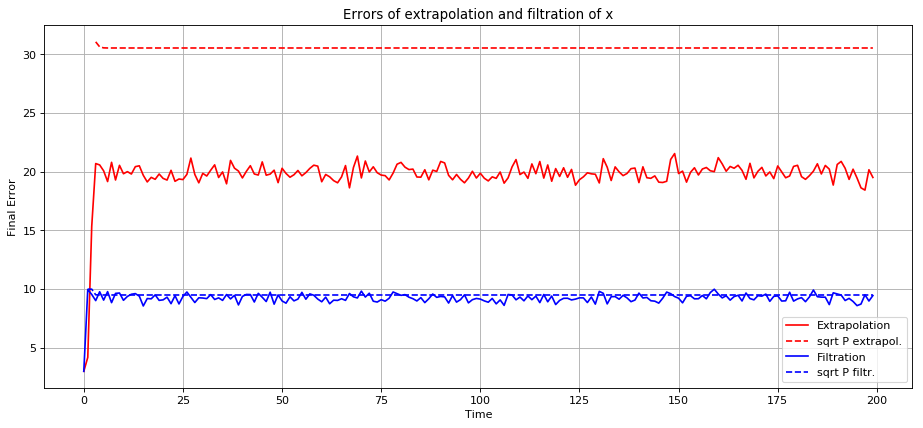

In [23]:
M_runs_plot(q_determined, 10*sigma_a_determined, sigma_eta_determined)

c) 10 times less sigma_a, other values as determined in Part I

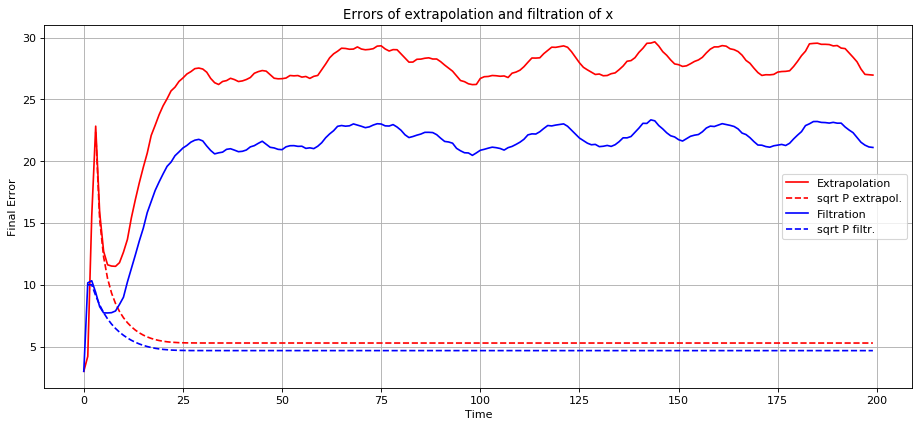

In [24]:
M_runs_plot(q_determined, .1*sigma_a_determined, sigma_eta_determined)

d) 10 times greater sigma_eta, other values as determined in Part I

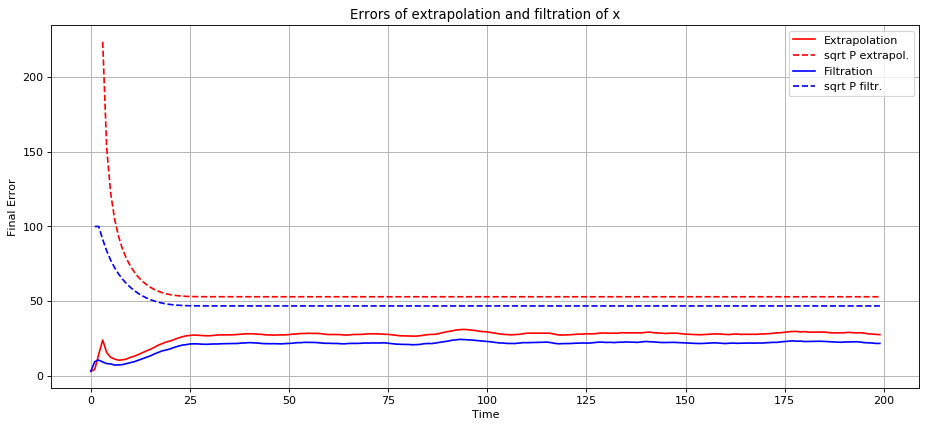

In [25]:
M_runs_plot(q_determined, sigma_a_determined, 10*sigma_eta_determined)

e) 10 times less sigma_eta, other values as determined in Part I

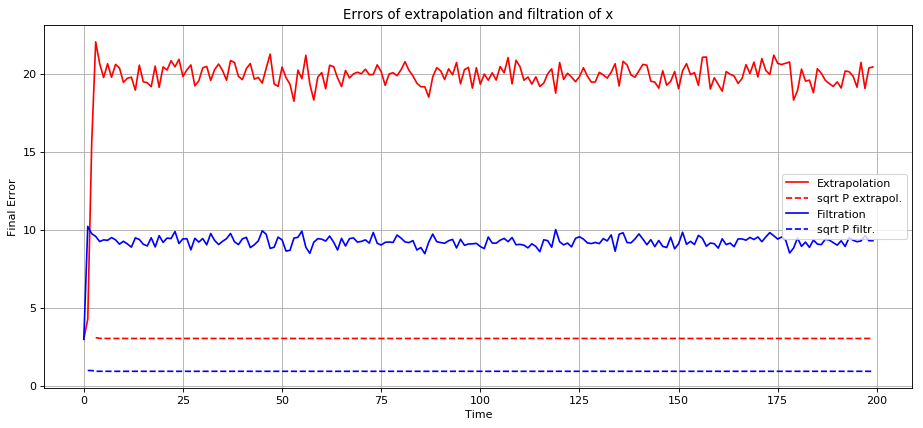

In [26]:
M_runs_plot(q_determined, sigma_a_determined, .1*sigma_eta_determined)

## Conclusion
Kalman Filter is sensitive to changes in values of measurement and disturbance noise and bias of acceleration of the tracked object. It was demonstrated, that not knowing the bias may increase error of prediction to be several times more. Bad determination of noises variances also decrease accuracy of prediction.<br>
Noise statistics identification and specification is crucial for optimal assimilation output. This is one of main difficulties of practical Kalman filter implementation.